### Verificação de Algoritmos

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['estou com todos sintomas covid devo preocupar' 1]
1044


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [5]:
validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [MinMaxScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            for metric in (
                cosine_similarity, 
                cosine_distances,
                laplacian_kernel, 
                euclidean_distances, 
                sigmoid_kernel, 
                chi2_kernel,
                polynomial_kernel,
                rbf_kernel
            ):
                for assign_labels in ["discretize", "kmeans"]:
                    clustering = SpectralClustering(
                        n_clusters=2,
                        eigen_solver="amg",
                        assign_labels=assign_labels,
                        affinity="precomputed_nearest_neighbors",
                        random_state=0,
                        n_jobs=-1
                    ).fit(metric(X))

                    pred = clustering.labels_
                    acc = round(accuracy_score(pred, y) * 100, 2)
                    f1 = round(f1_score(pred, y) * 100, 2)
                    vm = round(v_measure_score(y, pred), 2)
                    silhouette = None
                    try:
                        silhouette = silhouette_score(metric(X), pred, metric="precomputed")
                    except:
                        pass
                    validacoes.append((
                        vectorizer.__class__.__name__,
                        norm_name,
                        ngram_range,
                        metric.__name__,
                        assign_labels,
                        acc, 
                        f1,
                        vm,
                        silhouette
                    ))

In [6]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
165,TfidfVectorizer,MinMaxScaler,"(1, 1)",laplacian_kernel,kmeans,44.73,57.48,0.02,NaN
299,TfidfVectorizer,None,"(2, 3)",chi2_kernel,kmeans,44.06,57.31,0.01,NaN
293,TfidfVectorizer,None,"(2, 3)",laplacian_kernel,kmeans,43.77,57.31,0.01,NaN
53,CountVectorizer,MinMaxScaler,"(2, 3)",laplacian_kernel,kmeans,40.52,56.72,0.00,NaN
315,TfidfVectorizer,None,"(3, 3)",chi2_kernel,kmeans,41.09,56.60,0.00,NaN
309,TfidfVectorizer,None,"(3, 3)",laplacian_kernel,kmeans,40.33,56.59,0.00,NaN
63,CountVectorizer,MinMaxScaler,"(2, 3)",rbf_kernel,kmeans,40.42,56.56,0.00,NaN
197,TfidfVectorizer,MinMaxScaler,"(1, 3)",laplacian_kernel,kmeans,39.46,56.53,0.00,NaN
213,TfidfVectorizer,MinMaxScaler,"(2, 3)",laplacian_kernel,kmeans,39.46,56.53,0.00,NaN
229,TfidfVectorizer,MinMaxScaler,"(3, 3)",laplacian_kernel,kmeans,39.46,56.53,0.00,NaN


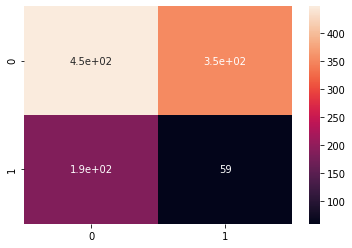

In [7]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(textos[:, 0]).todense()
X = MinMaxScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(laplacian_kernel(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [8]:
classifiers = [
#     LogisticRegression(
#         random_state=0,
#         n_jobs=-1
#     ), 
#     RidgeClassifier(
#         max_iter=500,
#         random_state=0,
#     ),
#     SGDClassifier(
#         random_state=0,
#         n_jobs=-1,
#         max_iter=1500,
#         n_iter_no_change=10
#     ), 
#     SVC(
#         kernel="linear",
#         random_state=0
#     ),
    MLPClassifier(
        hidden_layer_sizes=(100, 5),
        learning_rate_init=1e-2,
        random_state=0,
        max_iter=30
    )
]

validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [MinMaxScaler, StandardScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            for Classifier in classifiers:
                clf = Classifier.fit(X_train, y_train)
                pred = clf.predict(X_test)

                acc = round(accuracy_score(pred, y_test) * 100, 2)
                f1 = round(f1_score(pred, y_test) * 100, 2)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    clf.__class__.__name__,
                    acc, 
                    f1
                ))

In [9]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,F1
10,CountVectorizer,None,"(1, 1)",MLPClassifier,69.75,65.95
25,TfidfVectorizer,None,"(1, 1)",MLPClassifier,71.34,63.41
5,CountVectorizer,StandardScaler,"(1, 1)",MLPClassifier,69.75,63.32
16,TfidfVectorizer,MinMaxScaler,"(1, 2)",MLPClassifier,71.97,62.71
20,TfidfVectorizer,StandardScaler,"(1, 1)",MLPClassifier,69.43,62.50
2,CountVectorizer,MinMaxScaler,"(1, 3)",MLPClassifier,70.70,62.30
26,TfidfVectorizer,None,"(1, 2)",MLPClassifier,63.69,62.25
1,CountVectorizer,MinMaxScaler,"(1, 2)",MLPClassifier,67.52,61.65
18,TfidfVectorizer,MinMaxScaler,"(2, 3)",MLPClassifier,62.74,61.64
0,CountVectorizer,MinMaxScaler,"(1, 1)",MLPClassifier,64.65,61.05


66.56 65.8


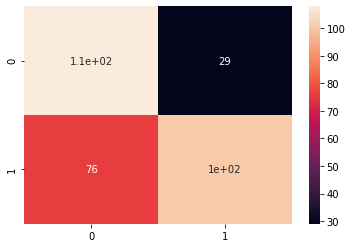

In [10]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(textos[:, 0]).todense()
X = MinMaxScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = MLPClassifier(
    hidden_layer_sizes=(100, 5),
    learning_rate_init=1e-2,
    random_state=0,
    max_iter=30
).fit(X_train, y_train)
pred = clf.predict(X_test)

acc = round(accuracy_score(pred, y_test) * 100, 2)
f1 = round(f1_score(pred, y_test) * 100, 2)
print(acc, f1)

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Unsupervised Learning : Word2Vec +  Spectral Clustering

In [11]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
print(f"Palavras no vocab: {len(list(w2v.wv.vocab))}")

# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format(f"{os.getcwd()}/../ai/models/skip_s300.txt")

Palavras no vocab: 210654


In [12]:
n_textos = []
for texto in textos:
    doc = []
    for palavra in texto[0].split():
        try:
            doc.append(w2v.wv[palavra])
        except:
            # print(palavra)
            # doc.append(np.ones((150, )))
            pass
    doc = np.asarray(doc)
    doc = np.mean(doc, axis=0)
    n_textos.append(doc)
n_textos = np.asarray(n_textos)

In [13]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    polynomial_kernel,
    rbf_kernel
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        silhouette = None
        try:
            silhouette = silhouette_score(metric(X), pred, metric="precomputed")
        except:
            pass
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm,
            silhouette
        ))

In [14]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Metric"], ascending=False)
df.head(25)

,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
10,rbf_kernel,discretize,36.69,46.39,0.03,NaN
9,polynomial_kernel,kmeans,50.29,46.33,0.00,NaN
7,sigmoid_kernel,kmeans,50.19,46.28,0.00,NaN
2,laplacian_kernel,discretize,37.45,45.72,0.02,NaN
6,sigmoid_kernel,discretize,50.48,45.41,0.00,NaN
8,polynomial_kernel,discretize,50.48,45.41,0.00,NaN
3,laplacian_kernel,kmeans,62.64,38.49,0.02,NaN
11,rbf_kernel,kmeans,62.93,36.66,0.02,NaN
0,cosine_distances,discretize,58.33,19.29,0.00,0.121383
4,euclidean_distances,discretize,58.72,18.83,0.00,0.130287


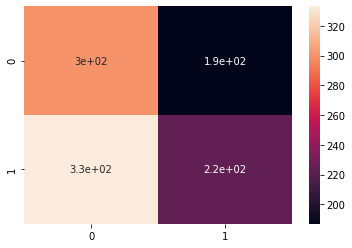

In [15]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(sigmoid_kernel(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Unsupervised Learning : Doc2Vec +  Spectral Clustering

In [16]:
from gensim.models import Doc2Vec

d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

In [17]:
n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=100)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [18]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    polynomial_kernel,
    rbf_kernel
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        silhouette = None
        try:
            silhouette = silhouette_score(metric(X), pred, metric="precomputed")
        except:
            pass
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm,
            silhouette
        ))

In [19]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Metric"], ascending=False)
df.head(25)

,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
2,laplacian_kernel,discretize,44.64,31.52,0.02,NaN
10,rbf_kernel,discretize,49.14,27.16,0.01,NaN
3,laplacian_kernel,kmeans,48.37,22.45,0.02,NaN
11,rbf_kernel,kmeans,51.15,21.78,0.01,NaN
6,sigmoid_kernel,discretize,59.39,17.83,0.00,NaN
8,polynomial_kernel,discretize,59.39,17.83,0.00,NaN
7,sigmoid_kernel,kmeans,60.34,8.00,0.00,NaN
9,polynomial_kernel,kmeans,60.34,8.00,0.00,NaN
0,cosine_distances,discretize,59.10,1.39,0.01,0.038926
4,euclidean_distances,discretize,59.77,0.94,0.00,0.237466


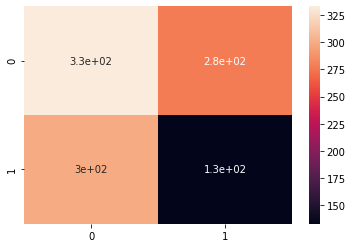

In [20]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(laplacian_kernel(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()